In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Define Import Path

In [2]:
# Get the current directory
current_dir = Path().absolute()

# Get folder path for model inputs
folder_path = current_dir / "Inputs"

## 2. Set Scenario Parameters

In [3]:
# distance limit
max_dis = 300

# Sampling number
num_samples = 1000

# Sludge mix rate
## For scenario: T1
MaxiRate = 0.05  ### Maximum mix rate of sludge mass in total fuel mass
l_ratio = 0.2  ### The ratio of lower bound to maximum mix rate: MixRate
## For scenario: T2
# MaxiRate = 0.2
# l_ratio = 0.05

# Fuel Price 
Coal_Price_5500 = 557 # optional: 557(C1) 791(C2)

## 3. Define Export Path

In [4]:
# Path for optimization results
folder_GHG = current_dir / f"Outputs/Sludge_TW_{num_samples}_M{MaxiRate}_L{l_ratio}_{Coal_Price_5500}"
os.makedirs(folder_GHG, exist_ok=True)

# Path for optimization logs
log_dir = folder_GHG / f"logs"
os.makedirs(log_dir, exist_ok=True)

## 4. Data Import

In [5]:
# MWWTP

file_WWTP = os.path.join(folder_path, "WWTP_45%wc.xlsx")
df_WWTP = pd.read_excel(file_WWTP)

In [6]:
# CFPP

file_CFPP =  os.path.join(folder_path, "CFPP.xlsx")
df_CFPP = pd.read_excel(file_CFPP)

file_plant_coal =  os.path.join(folder_path, "coal-fired_power_plants_China_2020_operating.xlsx")
df_plant_coal = pd.read_excel(file_plant_coal)

In [7]:
# MSWIP

file_MSWIP =  os.path.join(folder_path, "MSWIP.xlsx")
df_MSWIP = pd.read_excel(file_MSWIP)

file_plant_waste =  os.path.join(folder_path, "waste_inceration_plants_2020_operating.xlsx")
df_plant_waste = pd.read_excel(file_plant_waste)

In [8]:
# Distance for possible TFPP-MWWTP synergy

file_dis_CFPP = os.path.join(folder_path, f"distance_cfpp_nation_300.csv") 
df_dis_cfpp = pd.read_csv(file_dis_CFPP)

file_dis_MSWIP = os.path.join(folder_path, f"distance_mswip_nation_300.csv")
df_dis_mswip = pd.read_csv(file_dis_MSWIP)

In [9]:
# Provincal data

file_intesity =  os.path.join(folder_path, "province_intensity.xlsx")
df_intesity = pd.read_excel(file_intesity)

In [10]:
# Costs for Monte Carlo Simulation

## Net costs
file_NC =  os.path.join(folder_path, f"NC_old_nation_{num_samples}_monthly.csv")
df_nc = pd.read_csv(file_NC)

## TC_coal
file_TC_coal =  os.path.join(folder_path, f"TC_coal_{num_samples}.xlsx")
df_TC_coal = pd.read_excel(file_TC_coal)

## NC_cowaste
file_NC_cowaste =  os.path.join(folder_path, f"NC_cowaste_{num_samples}.xlsx")
df_NC_cowaste = pd.read_excel(file_NC_cowaste)

## 5. Input Data & Parameters

In [11]:
# GHG emission factors (water content: 45%)

GHG_SludgeBurn = 0.0798 # sludge burning on average (tCO2eq/t)
GHG_SludgeInci = -0.3163 # sludge incineration with energy recovery (tCO2eq/t)
GHG_SludgeLandfill = 0.8672 # sanitary landfill (tCO2eq/t)
GHG_SludgeLandApp = (0.1065+0.3184)/2 # land application (tCO2eq/t)
GHG_SludgeBuild = -0.1701 # building material utilization (tCO2eq/t)
GHG_SludgeOther = 0.1124 #  other applications (tCO2eq/t)

GHG_CoalBurn = 1.99 # coal burning on average (tCO2eq/t)
GHG_CoalMini = 0.18 # coal mining and processing (tCO2eq/t)

GHG_SludgeTrans = 0.123/1000 # sludge transport (tCO2eq/km)

GHG_Elec_province = dict(zip(df_intesity['Province'], df_intesity['GHG_emis_tCO2eq/kWh'])) # grid electricity (tCO2eq/kWh)

In [12]:
# Fuel Costs (water content: 45%)

Coal_Price_province = dict(zip(df_intesity['Province'], df_intesity['Coal_price_index']*Coal_Price_5500))

In [13]:
# The j-th CFPP's GHG emission factor derived from local grid averages: GHG_Elec_coal[j]   
# The j-th CFPP's fuel cost derived from provincial averages: Coal_price[j]  

region_j = df_plant_coal['Province']
GHG_Elec_coal = dict()
Coal_price= dict()

for j in range(len(region_j)):
    GHG_Elec_coal[j] = GHG_Elec_province[region_j[j]]
    Coal_price[j] = Coal_Price_province[region_j[j]]

In [14]:
# The k-th MSWIP's GHG emission factor derived from local grid averages: GHG_Elec_waste[k] 

region_k = df_plant_waste['Pro_en']
GHG_Elec_waste = dict()
for k in range(len(region_k)):
    GHG_Elec_waste[k] = GHG_Elec_province[region_k[k]]

In [15]:
# The available volume of dewatered sludge generated by the i-th MWWTP in the m-th month: SludgeSupply[i,m] 
# The weighted average emission factor for original disposal approaches: SludgeTreatmentfactor[i,m]

month_WWTP = df_WWTP['Statistical month']
supply = df_WWTP['total_sludge_treated'] # Total sludge treated (ton/month, 45% moisture content)
landapp = df_WWTP['land_application']
building = df_WWTP['building_materials']
incineration = df_WWTP['incineration']
landfill = df_WWTP['landfill']
other = df_WWTP['other_disposal']
item = df_WWTP['Plantcode']

SludgeSupply = dict() 
SludgeTreatmentfactor = dict() 
wwtp_counter = 0

for k in range(len(month_WWTP)):
    m = int(month_WWTP[k])-202000-1
    SludgeSupply[wwtp_counter, m] = round(supply[k]/1000,2)
    
    if supply[k] == 0:
        SludgeTreatmentfactor[wwtp_counter, m] = round(0,2)
    else: SludgeTreatmentfactor[wwtp_counter, m] = round((landapp[k]*GHG_SludgeLandApp+building[k]*GHG_SludgeBuild+
                                                                 incineration[k]*GHG_SludgeInci+landfill[k]*GHG_SludgeLandfill+
                                                                 other[k]*GHG_SludgeOther)/supply[k],2)
     
    if m == 11:
        wwtp_counter = wwtp_counter + 1

In [16]:
# The weighted average net cost for original disposal approaches: NC_old[i,num]

NC_old = df_nc.set_index(['num', 'FID', 'm'])['value'].to_dict()

In [17]:
# The net cost for sludge co-firing in MSWIPs: NC_cowaste
# The net cost for sludge co-firing in CFPPs: TC_coal

NC_cowaste = dict()
TC_coal =dict()
for num in range(num_samples):
    NC_cowaste[num] = df_NC_cowaste['NC_cowaste'][num]
    TC_coal[num] = df_TC_coal['TC_coal'][num]

In [18]:
# The maximum monthly co-firing capacity for the j-th CFPP: SludgeDemand_CFPP[j,m]

month_CFPP = df_CFPP['Statistical month']
demand_CFPP_1 = df_CFPP['Monthly_Coal_Ele_tce'] * MaxiRate
demand_CFPP_2 = df_CFPP['Monthly_Coal_Heat_tce'] * MaxiRate
demand_CFPP = demand_CFPP_1 + demand_CFPP_2

SludgeDemand_CFPP = dict() 
cfpp_counter = 0

for l in range(len(month_CFPP)):
    m_C = int(month_CFPP[l])-202000-1
    SludgeDemand_CFPP[cfpp_counter, m_C] = round(demand_CFPP[l]/0.7143/1000,2) #tce→kt
    
    if m_C == 11:
        cfpp_counter = cfpp_counter + 1

In [19]:
# The maximum monthly co-firing capacity for the k-th MSWIP: SludgeDemand_MSWIP[k,m]

month_MSWIP = df_MSWIP['Statistical month']
demand_MSWIP_1 = df_MSWIP['Monthly_Waste_Ele_t'] * MaxiRate
demand_MSWIP_2 = df_MSWIP['Monthly_Waste_Heat_t'] * MaxiRate
demand_MSWIP = demand_MSWIP_1 + demand_MSWIP_2

SludgeDemand_MSWIP = dict() 
mswip_counter = 0

for o in range(len(month_MSWIP)):
    m_w = int(month_MSWIP[o])-202000-1
    SludgeDemand_MSWIP[mswip_counter, m_w] = demand_MSWIP[o]/1000 
    
    if m_w == 11:
        mswip_counter = mswip_counter + 1

In [20]:
# The MWWTP-CFPP distance: Distance_CFPP[i,j] km
# The MWWTP-CFPP distance for a given month: annual_Distance_CFPP[i,j,m] km

distance_cfpp = df_dis_cfpp['distance']
WWTP = df_dis_cfpp['INPUT_FID']
CFPP = df_dis_cfpp['NEAR_FID']

Distance_CFPP = dict()
annual_Distance_CFPP = dict()

for p in range(len(distance_cfpp)):
    wwtp = int(WWTP[p])
    cfpp = int(CFPP[p])
    Distance_CFPP[wwtp, cfpp] = round(distance_cfpp[p],2)
    
    for m in range(12):
        annual_Distance_CFPP[wwtp,cfpp,m] = round(distance_cfpp[p],2)   

In [21]:
# MWWTP-CFPP pairs involving the i-th MWWTP：WWTP_cfpp_possiblelinkage[i]:[(i,1),(i,7)]
# List of MWWTPs within economical transport distance：wwtp_cfpp_list = []

WWTP_cfpp_possiblelinkage = dict()
wwtp_cfpp_list = []

for key in Distance_CFPP.keys():
    first_digit = key[0]
    
    if first_digit not in WWTP_cfpp_possiblelinkage:
        WWTP_cfpp_possiblelinkage[first_digit] = []  
        
    WWTP_cfpp_possiblelinkage[first_digit].append(key) 
    
    if first_digit not in wwtp_cfpp_list:
        wwtp_cfpp_list.append(first_digit) 

In [22]:
# MWWTP-CFPP pairs involving the i-th MWWTP for a given month：annual_WWTP_cfpp_pl[i,m]：[(i,1,m),(i,8,m),....]

annual_WWTP_cfpp_pl = dict()


for wwtp in wwtp_cfpp_list:
    for m in range(12):
        annual_WWTP_cfpp_pl[wwtp, m] = []

for key in annual_Distance_CFPP.keys():
    digit_1 = key[0] # WWTPs
    digit_3 = key[2] # month
    annual_WWTP_cfpp_pl[digit_1,digit_3].append(key)

In [23]:
# MWWTP-CFPP pairs involving the j-th CFPP：CFPP_possiblelinkage[j]: [(1,j),(7,j)]
# List of CFPPs within economical transport distance：cfpp_list = []

CFPP_possiblelinkage = {}
cfpp_list = []

for key in sorted(Distance_CFPP.keys(), key=lambda x: x[1]): # 将 Distance_CFPP 字典的键进行排序，排序的依据是键的第二个元素。
    second_digit = key[1]
    
    if second_digit not in CFPP_possiblelinkage:
        CFPP_possiblelinkage[second_digit] = [] 
        
    CFPP_possiblelinkage[second_digit].append(key) 
    
    if second_digit not in cfpp_list:
        cfpp_list.append(second_digit)    

In [24]:
# MWWTP-CFPP pairs involving the j-th CFPP for a given month：annual_CFPP_possiblelinkage[j,m]

annual_CFPP_possiblelinkage = dict()


for cfpp in cfpp_list:
    for m in range(12):
        annual_CFPP_possiblelinkage[cfpp, m] = []

for key in annual_Distance_CFPP.keys():
    digit_2 = key[1] # CFPPs
    digit_3 = key[2] # month
    annual_CFPP_possiblelinkage[digit_2,digit_3].append(key)
    
## For example：annual_Distance_CFPP.keys(): (0,465,0),(0,465,1),.....,(0,465,11),(0,464,0),(0,464,1),.....,(0,464,11)
## annual_CFPP_possiblelinkage[j,m]→[0,0]:(0,465,0),(0,464,0) [0,1]:(0,465,1),(0,464,1)....

In [25]:
# The MWWTP-MSWIP distance: Distance_MSWIP[i,k] km
# The MWWTP-MSWIP distance for a given month: annual_Distance_MSWIP[i,k,m] km

distance_mswip = df_dis_mswip['distance']
WWTP = df_dis_mswip['INPUT_FID']
MSWIP = df_dis_mswip['NEAR_FID']

Distance_MSWIP = dict()
annual_Distance_MSWIP = dict()

for q in range(len(distance_mswip)):
    wwtp = int(WWTP[q])
    mswip = int(MSWIP[q])
    Distance_MSWIP[wwtp, mswip] = round(distance_mswip[q],2)
    
    for m in range(12):
        annual_Distance_MSWIP[wwtp,mswip,m] = round(distance_mswip[q],2) 

In [26]:
# MWWTP-MSWIP pairs involving the i-th MWWTP：WWTP_mswip_possiblelinkage[i]
# List of MWWTPs within economical transport distance：wwtp_mswip_list = []


WWTP_mswip_possiblelinkage = dict()
wwtp_mswip_list = []

for key in Distance_MSWIP.keys():
    first_digit = key[0]
    
    if first_digit not in WWTP_mswip_possiblelinkage:
        WWTP_mswip_possiblelinkage[first_digit] = []  
        
    WWTP_mswip_possiblelinkage[first_digit].append(key)   
    
    if first_digit not in wwtp_mswip_list:
        wwtp_mswip_list.append(first_digit) 

In [27]:
# MWWTP-MSWIP pairs involving the i-th MWWTP for a given month：annual_WWTP_mswip_pl[i,m]：[(i,1,m),(i,8,m),....]

annual_WWTP_mswip_pl = dict()


for wwtp in wwtp_mswip_list:
    for m in range(12):
        annual_WWTP_mswip_pl[wwtp, m] = []

for key in annual_Distance_MSWIP.keys():
    digit_1 = key[0] # MMWTP
    digit_3 = key[2] # month
    annual_WWTP_mswip_pl[digit_1,digit_3].append(key)

In [28]:
# The potential MWWTP-MSWIP pairs involving the k-th MSWIP：MSWIP_possiblelinkage[k]:[(i,k)]
# List of MSWIPs within economical transport distance：mswip_list = []


MSWIP_possiblelinkage = dict()
mswip_list = []

for key in sorted(Distance_MSWIP.keys(), key=lambda x: x[1]): 
    second_digit = key[1]
    
    if second_digit not in MSWIP_possiblelinkage:
        MSWIP_possiblelinkage[second_digit] = [] 
        
    MSWIP_possiblelinkage[second_digit].append(key) 
    
    if second_digit not in mswip_list:
        mswip_list.append(second_digit)    

In [29]:
# MWWTP-MSWIP pairs involving the k-th MSWIP for a given month：annual_MSWIP_possiblelinkage[k,m]

annual_MSWIP_possiblelinkage = dict()


for mswip in mswip_list:
    for m in range(12):
        annual_MSWIP_possiblelinkage[mswip, m] = []

for key in annual_Distance_MSWIP.keys():
    digit_2 = key[1]
    digit_3 = key[2]
    annual_MSWIP_possiblelinkage[digit_2,digit_3].append(key)

## 6. Model Development and Optimization (TFPP-based Pathways)

In [30]:
# Define the model for 1000 Monte Carlo Simulation
# Unit：ktCO2eq, Thounsand CNY

def Optimize_GHG_02_Nation(num,log_filepath):

    # Model Parameters
    I = 5218 #No.WWTPs
    M = 12 # Months

    # Create a new model
    model = gp.Model("GHG_emission_nation")
    
    # Define the folder path of log file
    model.setParam("LogFile", log_filepath)

    # Create variables
    weight_cfpp = model.addVars(annual_Distance_CFPP.keys(),lb=0,vtype = GRB.CONTINUOUS,name='weight_cfpp')
    weight_mswip = model.addVars(annual_Distance_MSWIP.keys(),lb=0,vtype = GRB.CONTINUOUS,name='weight_mswip')
    z_cfpp = model.addVars(cfpp_list,vtype = GRB.BINARY, name='z_cfpp')
    z_mswip = model.addVars(mswip_list,vtype = GRB.BINARY, name='z_mswip')


    # Define the component of objective
    # onsite fuel combustion - coal sludge
    obj1 = gp.quicksum(weight_cfpp[index]*(GHG_SludgeBurn) 
                       for index in annual_Distance_CFPP.keys())
    
    obj2 = gp.quicksum(weight_cfpp[index]*(-0.48*GHG_CoalBurn) 
                       for index in annual_Distance_CFPP.keys())

    # sludge treatment - coal
    obj3 = gp.quicksum(-weight_cfpp[index]*SludgeTreatmentfactor[index[0],index[2]] 
                       for index in annual_Distance_CFPP.keys())

    # sludge dehydration - coal
    obj4 = gp.quicksum(weight_cfpp[index]*28*GHG_Elec_coal[index[1]] 
                       for index in annual_Distance_CFPP.keys())

    # sludge transport - coal
    obj5 = gp.quicksum(weight_cfpp[index]*GHG_SludgeTrans*annual_Distance_CFPP[index] 
                       for index in annual_Distance_CFPP.keys())

    # offsite coal mining and processing - coal
    obj6 = gp.quicksum(-weight_cfpp[index]*0.48*GHG_CoalMini 
                       for index in annual_Distance_CFPP.keys())

    # onsite fuel combustion - waste
    obj7 = gp.quicksum(weight_mswip[mswip_index]*GHG_SludgeBurn 
                       for mswip_index in annual_Distance_MSWIP.keys())

    # sludge treatment - waste
    obj8 = gp.quicksum(-weight_mswip[mswip_index]*SludgeTreatmentfactor[mswip_index[0],mswip_index[2]] 
                       for mswip_index in annual_Distance_MSWIP.keys())

    # sludge dehydration - waste
    obj9 = gp.quicksum(weight_mswip[mswip_index]*28*GHG_Elec_waste[mswip_index[1]] 
                       for mswip_index in annual_Distance_MSWIP.keys())

    # sludge transport - waste
    obj10 = gp.quicksum(weight_mswip[mswip_index]*GHG_SludgeTrans*annual_Distance_MSWIP[mswip_index] 
                       for mswip_index in annual_Distance_MSWIP.keys())

    # Set objective
    model.setObjective(obj1+obj2+obj3+obj4+obj5+obj6+obj7+obj8+obj9+obj10
                       ,GRB.MINIMIZE)
    

    # Add constraints: 1) The monthly sludge supply ceiling from each MWWTP
    for i in range(I):
        for m in range(M):
            ## 初始化提供给不同电厂的污泥量总和
            supply_to_cfpp = 0
            supply_to_mswip = 0
            flag = 0

            if i in WWTP_cfpp_possiblelinkage.keys(): # 检查 i 污水厂- j 煤电厂是否在可能的协同方案中
                for linkage_cfpp in WWTP_cfpp_possiblelinkage[i]:
                    j = linkage_cfpp[1]
                    supply_to_cfpp += weight_cfpp[i,j,m]
            else:
                flag += 1

            if i in WWTP_mswip_possiblelinkage.keys(): # 检查 i 污水厂- k生活垃圾焚烧厂是否在可能的协同方案中
                for linkage_mswip in WWTP_mswip_possiblelinkage[i]:
                    k = linkage_mswip[1]
                    supply_to_mswip += weight_mswip[i,k,m]
            else:
                flag += 1

            if flag < 2:
                model.addConstr(supply_to_cfpp + supply_to_mswip <= SludgeSupply[i,m])     

                
    # Add constraints: 2) The technology-dependent upper bound of monthly sludge co-firing at each TFPP
    model.addConstrs(gp.quicksum(weight_cfpp[cfpp_link] for cfpp_link in annual_CFPP_possiblelinkage[j,m]) <= SludgeDemand_CFPP[j,m]*z_cfpp[j] 
                     for j in cfpp_list for m in range(M))
    model.addConstrs(gp.quicksum(weight_mswip[mswip_link] for mswip_link in annual_MSWIP_possiblelinkage[k,m]) <= SludgeDemand_MSWIP[k,m]*z_mswip[k] 
                     for k in mswip_list for m in range(M))
    
    
    # Add constraints: 3) The lower threshold for reliable monthly sludge supply to TFPPs
    model.addConstrs(gp.quicksum(weight_cfpp[cfpp_link] for cfpp_link in annual_CFPP_possiblelinkage[j,m]) >= l_ratio*SludgeDemand_CFPP[j,m]*z_cfpp[j] 
                     for j in cfpp_list for m in range(M))
    model.addConstrs(gp.quicksum(weight_mswip[mswip_link] for mswip_link in annual_MSWIP_possiblelinkage[k,m]) >= l_ratio*SludgeDemand_MSWIP[k,m]*z_mswip[k] 
                     for k in mswip_list for m in range(M))
    
    
    # Add constraints: 4) Economic feasibility constraints (by plant annual profit)
    model.addConstrs(
        gp.quicksum(weight_cfpp[cfpp_link[0],j,m] * (Distance_CFPP[cfpp_link[0],j]*0.65-0.48*Coal_price[j]-NC_old[num,cfpp_link[0],m]+TC_coal[num]) 
                    for m in range(M) 
                    for cfpp_link in annual_CFPP_possiblelinkage[j,m]
                   ) <= 0 
        for j in cfpp_list
    )
    
    model.addConstrs(
        gp.quicksum(weight_mswip[mswip_link[0],k,m]*(Distance_MSWIP[mswip_link[0], k]*0.65 - NC_old[num,mswip_link[0],m] + NC_cowaste[num]-100)
                    for m in range(M)
                    for mswip_link in annual_MSWIP_possiblelinkage[k,m]
                   ) <= 0
        for k in mswip_list
    )
    
    
    # Set the MIPGap parameter to 0.01（1%）
    model.setParam('MIPGap', 0.01)
#     model.setParam('Method', 2)
#     model.setParam('NodeMethod', 2)
#     model.setParam('TimeLimit',7200)
#     model.write(f'{log_dir}/mymodel_{num}.mps')
                
    # Optimize model
    model.optimize()
    
    # Obtain the objective value
    obj_expr = model.getObjective()
    obj_value = obj_expr.getValue()
    
    # Obtain the objective values of each life-cycle
    obj_values = [obj1, obj2, obj3, obj4, obj5, obj6, obj7, obj8, obj9,obj10]
    obj_vals = [obj.getValue() for obj in obj_values]
    
    return model,weight_cfpp,weight_mswip,z_cfpp,z_mswip,obj_value,*obj_vals

In [ ]:
# Function Execution and Result Storage

unit_obj_02 = []

# for num in range(num_samples): 
for num in range(794,num_samples):

    log_filename = f"GHG_02_nation_{num}.log"
    log_filepath = os.path.join(log_dir, log_filename)    
    
#     model,weight_cfpp,weight_mswip,obj_value,*obj_vals = Optimize_GHG_02_Nation(num,log_filepath)
    model,weight_cfpp,weight_mswip,z_cfpp,z_mswip,obj_value,*obj_vals = Optimize_GHG_02_Nation(num,log_filepath)
    obj1_val, obj2_val, obj3_val, obj4_val, obj5_val, obj6_val, obj7_val, obj8_val, obj9_val, obj10_val = obj_vals
    
    # Obtain the value of objective (CFPP-based Pathways)
    mix_1 = obj1_val+obj2_val+obj3_val+obj4_val+obj5_val+obj6_val    
        
    # Obtain the value of decision variables
    opt_weight_cfpp = model.getAttr("X",weight_cfpp)
    opt_weight_mswip = model.getAttr("X",weight_mswip)
    opt_z_cfpp = model.getAttr("X",z_cfpp)
    opt_z_mswip = model.getAttr("X",z_mswip)
    
    # Save the value of decision variables
    linkage_cfpp = {key: value for key, value in opt_weight_cfpp.items() if value > 0.0001} 
    cfpp = []
    for key,value in linkage_cfpp.items():
        i = key[0]
        j = key[1]
        m = key[2]
        cfpp.append([i, j, m, linkage_cfpp[key]]) 

    df_cfpp = pd.DataFrame(cfpp, columns=['I', 'J', 'M', 'opt_weight_cfpp'])
    excel_filename = os.path.join(folder_GHG, f"GHG_02_cfpp_{num}.csv")
    df_cfpp.to_csv(excel_filename, index=False)
    w_cfpp = df_cfpp['opt_weight_cfpp'].sum()
    
    linkage_mswip = {key: value for key, value in opt_weight_mswip.items() if value > 0.0001}
    mswip = []
    for key,value in linkage_mswip.items():
        i = key[0]
        k = key[1]
        m = key[2]
        mswip.append([i, k, m, linkage_mswip[key]]) 

    df_mswip = pd.DataFrame(mswip, columns=['I', 'K', 'M', 'opt_weight_mswip'])
    w_mswip = df_mswip['opt_weight_mswip'].sum()
    
    filename_mswip = os.path.join(folder_GHG, f"GHG_02_mswip_{num}.csv")
    df_mswip.to_csv(filename_mswip, index=False)
    
    n_cfpp = df_cfpp['J'].nunique()
    n_wwtp_to_cfpp = df_cfpp['I'].nunique()
    n_mswip = df_mswip['K'].nunique()
    n_wwtp_to_mswip = df_mswip['I'].nunique()
    
    z_cfpp_val = {key: value for key, value in opt_z_cfpp.items()}
    df_m_cfpp = pd.DataFrame(list(z_cfpp_val.items()), columns=['J', 'z_cfpp'])
    df_m_cfpp.to_csv(os.path.join(folder_GHG, f"z_cfpp_{num}.csv"), index=False)
    n_cfpp = df_m_cfpp['z_cfpp'].sum()

    z_mswip_val = {key: value for key, value in opt_z_mswip.items()}
    df_m_mswip = pd.DataFrame(list(z_mswip_val.items()), columns=['K', 'z_mswip'])
    df_m_mswip.to_csv(os.path.join(folder_GHG, f"z_mswip_{num}.csv"), index=False)
    n_mswip = df_m_mswip['z_mswip'].sum()
    
    unit_obj_02.append({
        'num':num,
        'obj1': obj1_val,
        'obj2': obj2_val,
        'obj3': obj3_val,
        'obj4': obj4_val,
        'obj5': obj5_val,
        'obj6': obj6_val,
        'obj7': obj7_val,
        'obj8': obj8_val,
        'obj9': obj9_val,
        'obj10': obj10_val,
        'mix_1': mix_1,        
        'mix_2': obj_value-mix_1,
        'obj_value': obj_value,
        'opt_weight_cfpp': w_cfpp,
        'opt_weight_mswip': w_mswip,
        'w_total': w_cfpp+w_mswip,
        'n_cfpp': n_cfpp,
        'n_mswip': n_mswip,
        'n_wwtp_to_cfpp': n_wwtp_to_cfpp,
        'n_wwtp_to_mswip': n_wwtp_to_mswip       
        })  
        

    
df_unit_obj_02 = pd.DataFrame(unit_obj_02)

analysis_folder = os.path.join(folder_GHG, "analysis")
os.makedirs(analysis_folder, exist_ok=True)
file_result = os.path.join(analysis_folder, f"result_02_{num_samples}_{max_dis}_2.csv")
df_unit_obj_02.to_csv(file_result,index=False)

In [32]:
df_unit_obj_02 = pd.DataFrame(unit_obj_02)

analysis_folder = os.path.join(folder_GHG, "analysis")
os.makedirs(analysis_folder, exist_ok=True)
file_result = os.path.join(analysis_folder, f"result_02_{num_samples}_{max_dis}.csv")
df_unit_obj_02.to_csv(file_result,index=False)

## 7. Overview of the Results

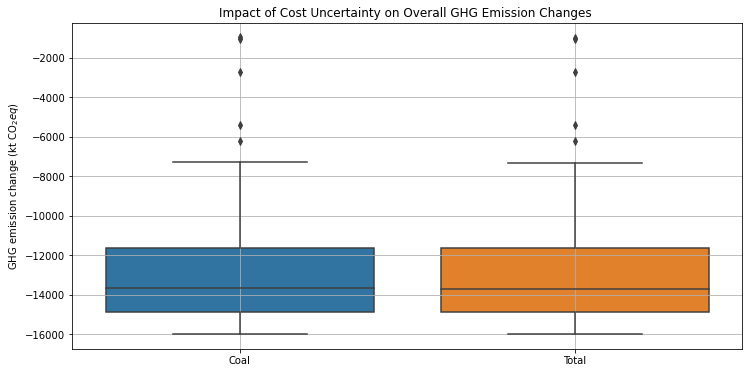

In [31]:
# Plot boxplots for mix_1 and mix_2 columns

# df_unit_obj_02 = pd.read_csv(os.path.join(folder_GHG,"result_02_100_300.csv"))
# df_unit_obj_02['obj_value'] = -df_unit_obj_02['obj_value']
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_unit_obj_02[['mix_1', 'obj_value']])
plt.title('Impact of Cost Uncertainty on Overall GHG Emission Changes ')
plt.ylabel('GHG emission change (kt CO$_2eq$)')
plt.xticks([0, 1], ['Coal',  'Total'])
plt.grid(True)

filepath = os.path.join(analysis_folder, f'Overall GHG Emission Changes_{num_samples}.png')
plt.savefig(filepath) 
plt.show()

## 8. Post-processing of Results

In [32]:
# Define the output folder of the processed results
output_path = os.path.join(folder_GHG, "num_processed")
os.makedirs(output_path, exist_ok=True)

In [33]:
origin_cfpp = ['opt_weight_cfpp' 
               ,'Sludge combustion','Coal combustion','Sludge treatment','Sludge dehydration','Sludge transport','Coal mining and processing'
               ,'Total_emission_change'
               ,'Transportation cost','Fuel cost change','Sludge treatment fee','Co-combustion cost'
               ,'Economic_total']

to_update_cfpp = ['opt_weight_cfpp'
                ,'GHGE_C1','GHGE_C2','GHGE_C3','GHGE_C4','GHGE_C5','GHGE_C6','GHGE_Ctotal'
                ,'E_C1','E_C2','E_C3','E_C4','E_Ctotal']

column_map_cfpp = dict(zip(to_update_cfpp, origin_cfpp))

In [34]:
origin_mswip = ['opt_weight_mswip' 
               ,'Fuel combustion','Sludge treatment','Sludge dehydration','Sludge transport'
               ,'Total_emission_change'
               ,'Transportation cost','Sludge treatment fee','Co-combustion cost'
               ,'Economic_total']

to_update_mswip = ['opt_weight_mswip'
               ,'GHGE_W1','GHGE_W2','GHGE_W3','GHGE_W4'
               ,'GHGE_Wtotal'
               ,'E_W1','E_W2','E_W3'
               ,'E_Wtotal']

column_map_mswip = dict(zip(to_update_mswip, origin_mswip))

In [35]:
# to get provincial list
df_tile = pd.read_excel(r"E:\Test\Outputs\FWC_03_S1\Tile_Grid_Map_Arrangement.xlsx")

# to_dict - map
df_plant_wwtp = pd.read_excel(r"E:\Test\Inputs\wastewater_treatment_plants_5218.xlsx")
i_province = df_plant_wwtp.set_index('FID')['Pro_en'].to_dict()

j_province = df_plant_coal.set_index('FID')['Province'].to_dict()
k_province = df_plant_waste.set_index('FID')['Pro_en'].to_dict()

j_cl = df_plant_coal.set_index('FID')['Capacity_MW'].to_dict()
k_cl = df_plant_waste.set_index('FID')['Capacity_elec_MW'].to_dict()

In [36]:
I_total_by_num = []

for num in range(num_samples):    

    file_cfpp = os.path.join(folder_GHG,fr"GHG_02_cfpp_{num}.csv")
    file_mswip = os.path.join(folder_GHG,fr"GHG_02_mswip_{num}.csv")
    df_cfpp = pd.read_csv(file_cfpp)
    df_mswip = pd.read_csv(file_mswip)
    
    sum_cfpp = df_cfpp.groupby('I')['opt_weight_cfpp'].sum().reset_index()
    sum_mswip = df_mswip.groupby('I')['opt_weight_mswip'].sum().reset_index()
    merged = pd.merge(sum_cfpp, sum_mswip, on='I', how='outer')
    merged['num'] = num
    merged = merged[['num', 'I', 'opt_weight_cfpp', 'opt_weight_mswip']]
    I_total_by_num.append(merged)
    


    # Convert to MultiIndex DataFrame for easy lookup
    df_cfpp.set_index(['I', 'J', 'M'], inplace=True)
    df_mswip.set_index(['I', 'K', 'M'], inplace=True)
    

    for col in origin_cfpp[1:]:  # 从第二个元素开始遍历
        df_cfpp[col] = 0
    df_cfpp['distance'] = 0
    
    df_cfpp['Sludge combustion'] = df_cfpp['opt_weight_cfpp'] * GHG_SludgeBurn
    df_cfpp['Coal combustion'] = df_cfpp['opt_weight_cfpp'] * (- 0.48 * GHG_CoalBurn) 
    df_cfpp['Coal mining and processing'] = -df_cfpp['opt_weight_cfpp']* 0.48 * GHG_CoalMini
    
    df_cfpp['Co-combustion cost'] = df_cfpp['opt_weight_cfpp']*TC_coal[num] 
    
    opt_weight_cfpp = df_cfpp['opt_weight_cfpp']
    for i, j, m in df_cfpp.index:
        opt_weight = opt_weight_cfpp.loc[(i, j, m)]
        df_cfpp.loc[(i, j, m), 'Sludge treatment'] = -opt_weight * SludgeTreatmentfactor[i, m]
        df_cfpp.loc[(i, j, m), 'Sludge dehydration'] = opt_weight * 28 * GHG_Elec_coal[j]
        df_cfpp.loc[(i, j, m), 'Sludge transport'] = opt_weight * GHG_SludgeTrans * Distance_CFPP[i, j]
        
        df_cfpp.loc[(i, j, m), 'Transportation cost'] = opt_weight * Distance_CFPP[i, j] * 0.65 
        df_cfpp.loc[(i, j, m), 'Fuel cost change'] = -opt_weight *0.48 * Coal_price[j] 
        df_cfpp.loc[(i, j, m), 'Sludge treatment fee'] = -opt_weight * NC_old[num,i,m]
        
        df_cfpp.loc[(i, j, m), 'distance'] = Distance_CFPP[i, j] 

    df_cfpp['Total_emission_change'] = df_cfpp[['Sludge combustion','Fuel combustion','Sludge treatment','Sludge dehydration','Sludge transport','Coal mining and processing']].sum(axis=1)
    df_cfpp['Economic_total'] = df_cfpp[['Transportation cost','Fuel cost change','Sludge treatment fee','Co-combustion cost']].sum(axis=1) 
    
        
    df_cfpp.reset_index(inplace=True)
    df_cfpp['i_pro'] = df_cfpp['I'].map(i_province)
    df_cfpp['j_pro'] = df_cfpp['J'].map(j_province)
    df_cfpp['cap_level'] = df_cfpp['J'].map(j_cl)
   
    
    cfpp_processed = os.path.join(output_path, fr"cfpp_{num}.csv")
    df_cfpp.to_csv(cfpp_processed, index=False)
    
      
            
    for col in origin_mswip[1:]:  
        df_mswip[col] = 0
    df_mswip['distance'] = 0   
    
    df_mswip['Fuel combustion'] = df_mswip['opt_weight_mswip'] * GHG_SludgeBurn 
   
    opt_weight_mswip = df_mswip['opt_weight_mswip']
    for i, k, m in df_mswip.index:
        opt_weight = opt_weight_mswip.loc[(i, k, m)]
        
        df_mswip.loc[(i, k, m), 'Sludge treatment'] = -opt_weight * SludgeTreatmentfactor[i, m]
        df_mswip.loc[(i, k, m), 'Sludge dehydration'] = opt_weight * 28 * GHG_Elec_waste[k] 
        df_mswip.loc[(i, k, m), 'Sludge transport'] = opt_weight * GHG_SludgeTrans * Distance_MSWIP[i, k]
        
        df_mswip.loc[(i, k, m), 'Transportation cost'] = opt_weight * Distance_MSWIP[i,k]*0.65 
        df_mswip.loc[(i, k, m), 'Sludge treatment fee'] = -opt_weight * NC_old[num,i,m] 
        df_mswip.loc[(i, k, m), 'Co-combustion cost'] = opt_weight * NC_cowaste[num] 
        
        df_mswip.loc[(i, k, m), 'distance'] = Distance_MSWIP[i,k] 
    
    df_mswip['Total_emission_change'] = df_mswip[['Fuel combustion','Sludge treatment','Sludge dehydration','Sludge transport']].sum(axis=1) 
    df_mswip['Economic_total'] = df_mswip[['Transportation cost','Sludge treatment fee','Co-combustion cost']].sum(axis=1)

        
    df_mswip.reset_index(inplace=True)
    df_mswip['i_pro'] = df_mswip['I'].map(i_province)
    df_mswip['k_pro'] = df_mswip['K'].map(k_province)
    df_mswip['cap_level'] = df_mswip['K'].map(k_cl)
    
    mswip_processed = os.path.join(output_path, fr"mswip_{num}.csv")
    df_mswip.to_csv(mswip_processed, index=False)    
    
                        
I_total = pd.concat(I_total_by_num, ignore_index=True)
I_total['opt_total'] = I_total['opt_weight_cfpp']+ I_total['opt_weight_mswip']
I_total.to_csv(os.path.join(analysis_folder, fr"I_total_by_num.csv"),index=False)